In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2025 -  United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by:    Laura Murgatroyd (STFC-UKRI)
#                  Franck Vidal (STFC-UKRI)
#                  Gemma Fardell (STFC-UKRI)

# Flexible Geometry

This notebook introduces the `Cone3D_Flex` `AcquisitionGeometry` which allows setting a different source and detector position for each acquired radiograph.

Learning objectives:
- Create a `Cone3D_Flex` `AcquisitionGeometry`
- Reconstruct using FDK from ASTRA
- Compare the forward projections to the radiographs
- Reconstruct using SIRT

In [2]:
from cil.io import TIFFStackReader
from cil.utilities.display import show2D, show_system_positions, show_geometry
from cil.framework import ImageGeometry, AcquisitionGeometry, AcquisitionData
import os
from cil.utilities.jupyter import islicer
import matplotlib
import numpy as np
from cil.plugins.astra import FBP
from cil.processors import TransmissionAbsorptionConverter

## Load the Radiographs

The data consists of TIFF files - the projections, and a CSV file which contains the source and detector positions for each angle

In [3]:
filepath=r"C:\Users\lhe97136\Work\GitHub\non-standard-CT\output\non-standard-trajectories\projections"


First let's load and view the projections

In [4]:
projection_array = TIFFStackReader(filepath).read()

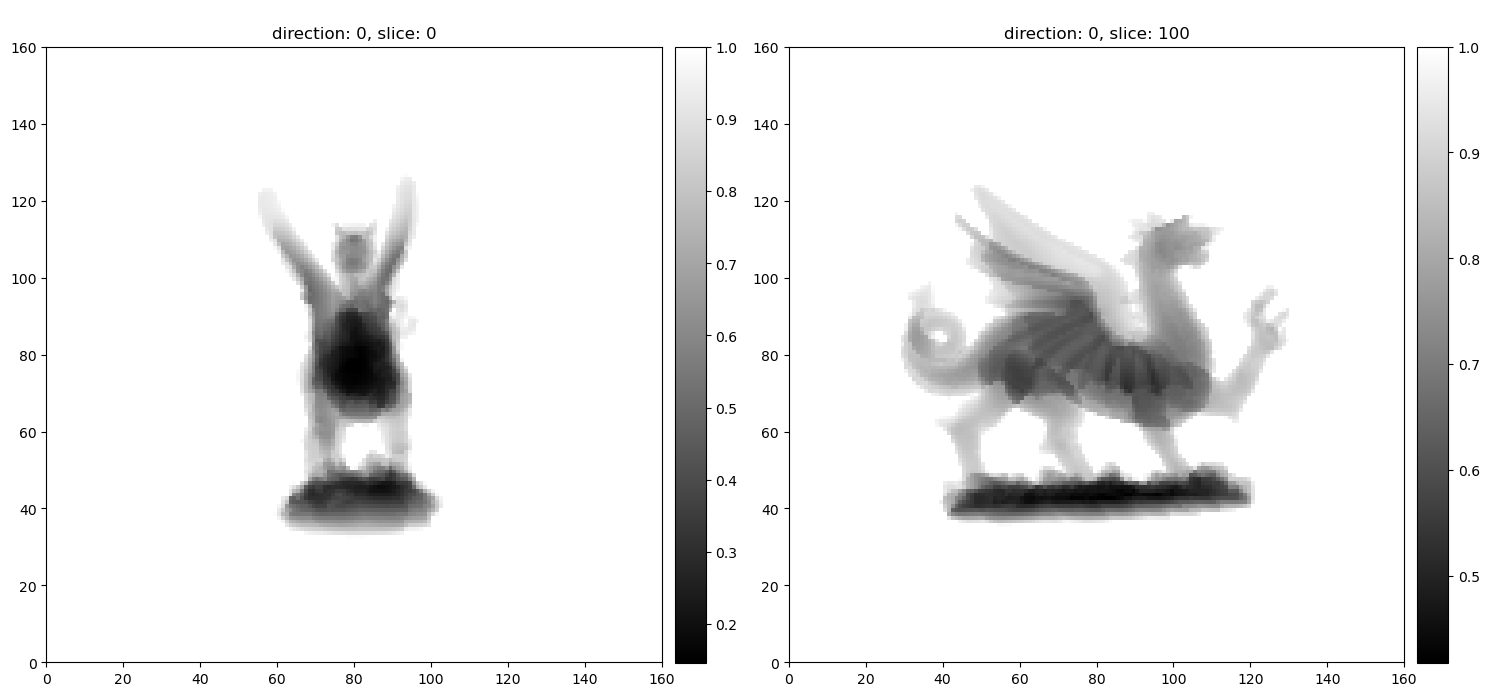

In [5]:
show2D([projection_array]*2, slice_list=[0,100])

In [6]:
print(projection_array.shape)

(500, 160, 160)


### Display the Sinogram

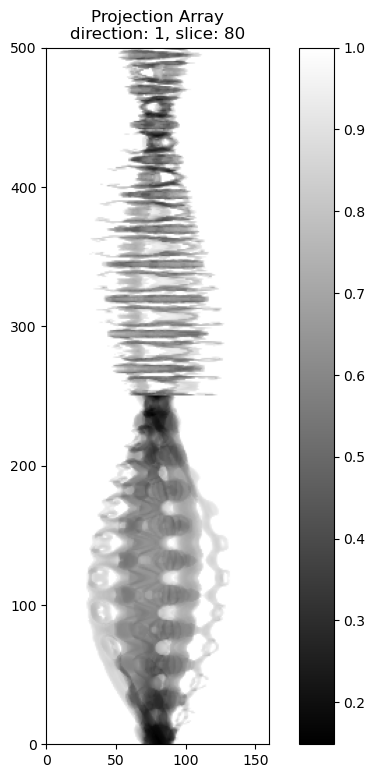

In [7]:
show2D([projection_array], slice_list=(1,80), title='Projection Array')

The sinogram looks strange! Let's examine the projections using islicer - do you see anything unusual?

In [8]:
islicer(projection_array, title='Projection Array')

It looks like the dragon is bouncing up and down! This is because some or all of the following are varying between each radiograph:
- detector position
- detector angle
- source position

The data came with a CSV file which describes this geometry for each radiograph.

# Read the Geometry Information

Now we'll read the information from the csv file:

In [9]:
csv_filepath = os.path.join(filepath, 'geom.csv') # remove angle from csv file

column_names = ["fname",
    "source position (x)", "source position (y)", "source position (z)",
    "imager centre (x)", "imager centre (y)", "imager centre (z)",
    "imager u vector (x)", "imager u vector (y)", "imager u vector (z)",
    "imager v vector (x)", "imager v vector (y)", "imager v vector (z)",
    "angle",
];

# fname,source position (x),source position (y),source position (z),imager centre (x),imager centre (y),imager centre (z),imager u vector (x),imager u vector (y),imager u vector (z),imager v vector (x),imager v vector (y),imager v vector (z),angle

# read the csv file:
import pandas as pd
df = pd.read_csv(csv_filepath)

source_position_set = df[['source position (x)', 'source position (y)', 'source position (z)']].values
detector_position_set = df[['imager centre (x)', 'imager centre (y)', 'imager centre (z)']].values
detector_direction_x_set = df[['imager u vector (x)', 'imager u vector (y)', 'imager u vector (z)']].values
detector_direction_y_set = df[['imager v vector (x)', 'imager v vector (y)', 'imager v vector (z)']].values


# Create a CIL Acquisition Geometry

To define the acquisition geometry in CIL, we create a Cone3D_Flex Acquisition Geometry.

This requires us to set:
- `source_position_set` - This is a list of 3D vectors describing the position of the source for each radiograph acquired.
- `detector_position_set` - This is a list of 3D vectors describing the position of the detector for each radiograph acquired.
- `detector_direction_x_set` - This is a list of 3D vectors describing the direction of the detector_x
- `detector_direction_y_set` - This is a list of 3D vectors describing the direction of the detector_y

We have read all of these from the csv in the cell above!

In [10]:
acq_geometry = AcquisitionGeometry.create_Cone3D_Flex(source_position_set, detector_position_set,
                                                detector_direction_x_set, detector_direction_y_set)


Note: we could also have set the `volume_centre_position`. This is a 3D vector describing the position of the centre of the reconstructed volume (x,y,z). We have not set this, which means it will be set to the default of [0,0,0]: the origin.

As with other geometry types in CIL, we also need to set the panel size, pixel size, and data labels. Printing the data shape and examining the radiographs we showed above helps us with this:

In [11]:
print(projection_array.shape)

(500, 160, 160)


We can see that we have 500 angles and our panel is 160x160

TODO: how do we explain where we get the pixel size from? We got it from gvxr originally
pixel_size = (0.25, 0.25) could get from norm of (x,y,z) vector

In [12]:
number_of_pixels = projection_array.shape[1:3]
pixel_size = (0.25, 0.25)

In [13]:
acq_geometry.set_panel(number_of_pixels, pixel_size)
acq_geometry.set_labels(['angle','vertical','horizontal'])

The standard CIL definitions of axes are shown in this image: REPLACE WITH SCRNSHOT FROM GVXR

![title](images/07_cone_geometry_example.png)

This display tool allows us to visualise the motion of the source and detector throughout the scan:

right handed coord system, see notebook 0 for specifics

coord system is aligned with the voxel grid. centre is on the origin unless you offset it in the ig, see how to do in geom notebk

units 


compare with normal CT scan plots

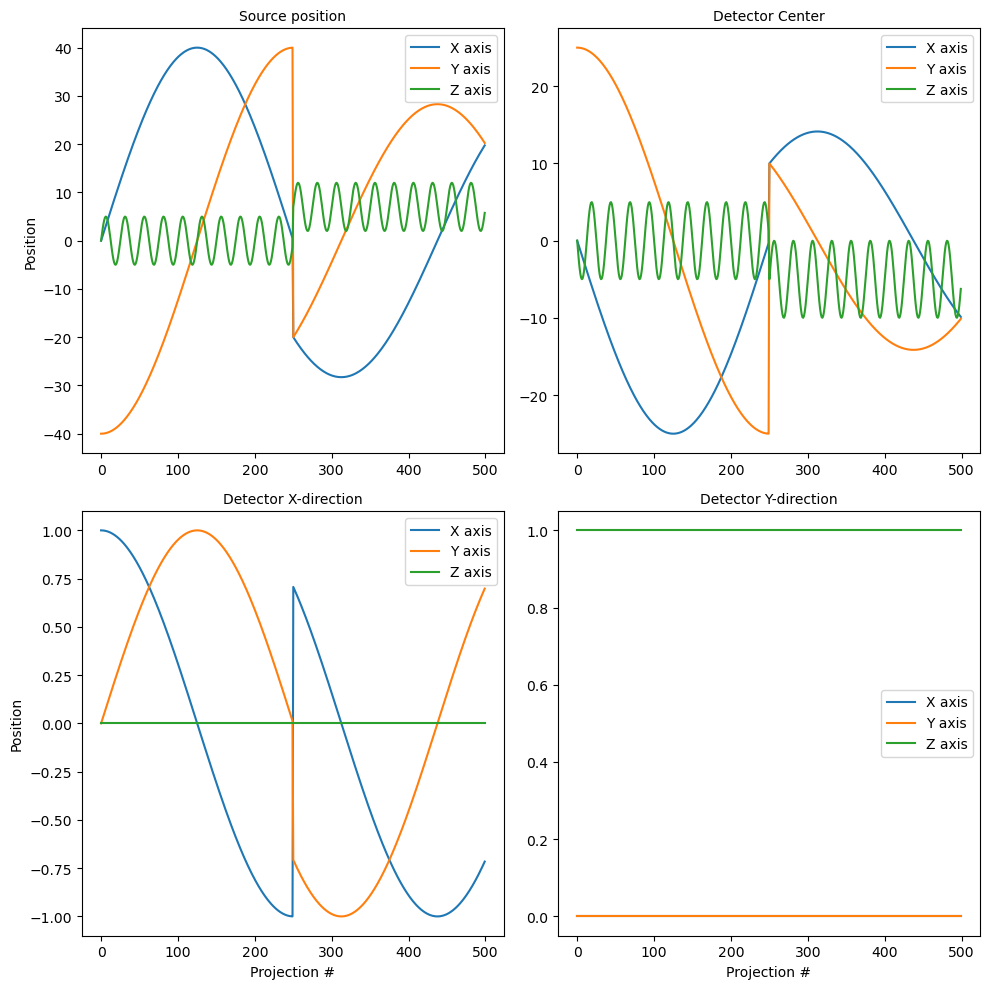

In [14]:
show_system_positions(acq_geometry);

If we print the acquisition geometry, we can also see the first few source and detector positions, and detector vectors:

In [15]:
print(acq_geometry)

Per-projection 3D Cone-beam tomography
System configuration:
	Number of projections: 500
	Source positions 0-9: [[  0.       ,-40.       ,  0.       ],
 [  0.5026416,-39.99684  ,  1.2434494],
 [  1.0052038,-39.987366 ,  2.4087684],
 [  1.5076073,-39.97158  ,  3.4227355],
 [  2.0097728,-39.94948  ,  4.2216396],
 [  2.5116208,-39.92107  ,  4.7552824],
 [  3.0130723,-39.886356 ,  4.990134 ],
 [  3.5140479,-39.845345 ,  4.911436 ],
 [  4.0144687,-39.798042 ,  4.524135 ],
 [  4.5142555,-39.744453 ,  3.8525662]]
	Detector positions 0-9: [[ 0.        ,25.        , 0.        ],
 [-0.314151  ,24.998026  ,-1.2434494 ],
 [-0.6282524 ,24.992105  ,-2.4087684 ],
 [-0.94225454,24.982237  ,-3.4227355 ],
 [-1.2561079 ,24.968424  ,-4.2216396 ],
 [-1.569763  ,24.950668  ,-4.7552824 ],
 [-1.8831701 ,24.928972  ,-4.990134  ],
 [-2.19628   ,24.90334   ,-4.911436  ],
 [-2.509043  ,24.873775  ,-4.524135  ],
 [-2.8214097 ,24.840282  ,-3.8525662 ]]
	Detector directions x 0-9: [[1.        ,0.        ,0.        ]

TODO: add comment about show_geometry not used for this geom type

# Reconstruct with ASTRA

Now we can create our CIL AcquisitionData as normal. We'll be reconstructing with ASTRA so we also reorder the data to enable this:

In [16]:
acq_data = AcquisitionData(projection_array, geometry=acq_geometry)
acq_data.reorder(order='astra')

In [17]:
print(acq_data)

Number of dimensions: 3
Shape: (160, 500, 160)
Axis labels: (<AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



In [18]:
from cil.processors import Slicer

slicer = Slicer(roi={'angle': (0, 180)})(acq_data)

180 0 1
Number of positions:  180
Source positions:  180
Detector positions:  180
New geometry:  Per-projection 3D Cone-beam tomography
System configuration:
	Number of projections: 180
	Source positions 0-9: [[  0.       ,-40.       ,  0.       ],
 [  0.5026416,-39.99684  ,  1.2434494],
 [  1.0052038,-39.987366 ,  2.4087684],
 [  1.5076073,-39.97158  ,  3.4227355],
 [  2.0097728,-39.94948  ,  4.2216396],
 [  2.5116208,-39.92107  ,  4.7552824],
 [  3.0130723,-39.886356 ,  4.990134 ],
 [  3.5140479,-39.845345 ,  4.911436 ],
 [  4.0144687,-39.798042 ,  4.524135 ],
 [  4.5142555,-39.744453 ,  3.8525662]]
	Detector positions 0-9: [[ 0.        ,25.        , 0.        ],
 [-0.314151  ,24.998026  ,-1.2434494 ],
 [-0.6282524 ,24.992105  ,-2.4087684 ],
 [-0.94225454,24.982237  ,-3.4227355 ],
 [-1.2561079 ,24.968424  ,-4.2216396 ],
 [-1.569763  ,24.950668  ,-4.7552824 ],
 [-1.8831701 ,24.928972  ,-4.990134  ],
 [-2.19628   ,24.90334   ,-4.911436  ],
 [-2.509043  ,24.873775  ,-4.524135  ],
 [-2.8

In [19]:
print(slicer)

Number of dimensions: 3
Shape: (160, 180, 160)
Axis labels: (<AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



We need to convert to absoprtion data first:

In [20]:
absorp_data = TransmissionAbsorptionConverter()(acq_data)

In [21]:
absorp_data.get_slice(angle=1)

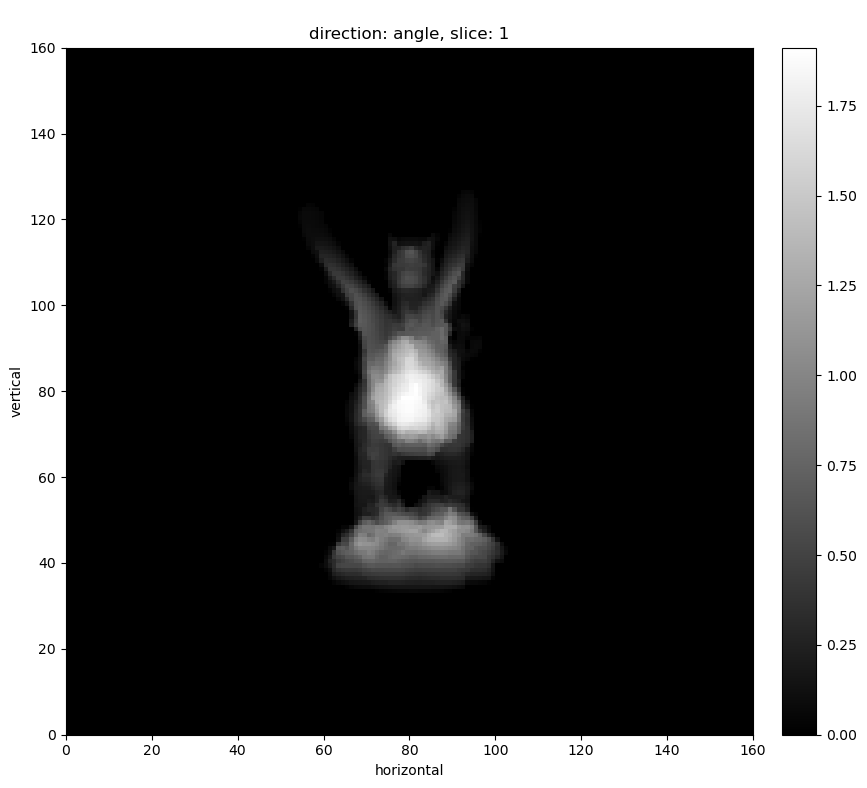

In [25]:
show2D(absorp_data, slice_list=('angle', 1))

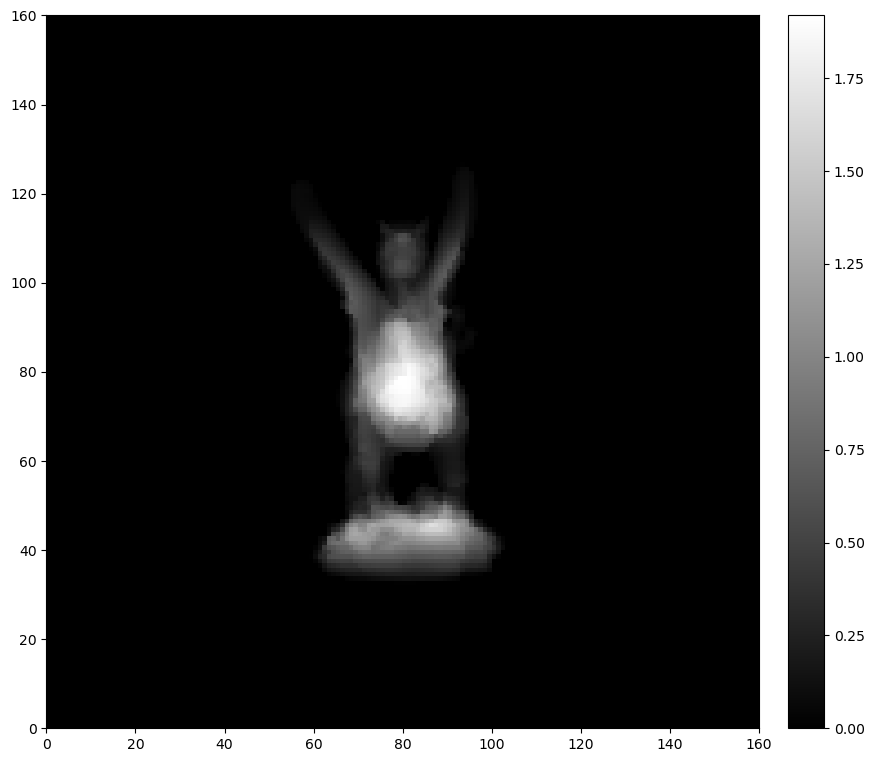

In [18]:
show2D(absorp_data.array[:,0])

Reconstructing requires setting an image geometry. This is the description of the reconstruction volume. We can get a default image geometry from our AcquisitionData:

In [19]:
image_geometry = absorp_data.geometry.get_ImageGeometry()
print(image_geometry)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x160,y160,z160
voxel_size : x0.1600000001425107,y0.1600000001425107,z0.1600000001425107
center : x0,y0,z0



The default ImageGeometry is constructed using an average of the magnification values across all of the projectons.

In [20]:
fbp = FBP(absorp_data.geometry.get_ImageGeometry(), absorp_data.geometry) 
fbp.set_input(absorp_data)

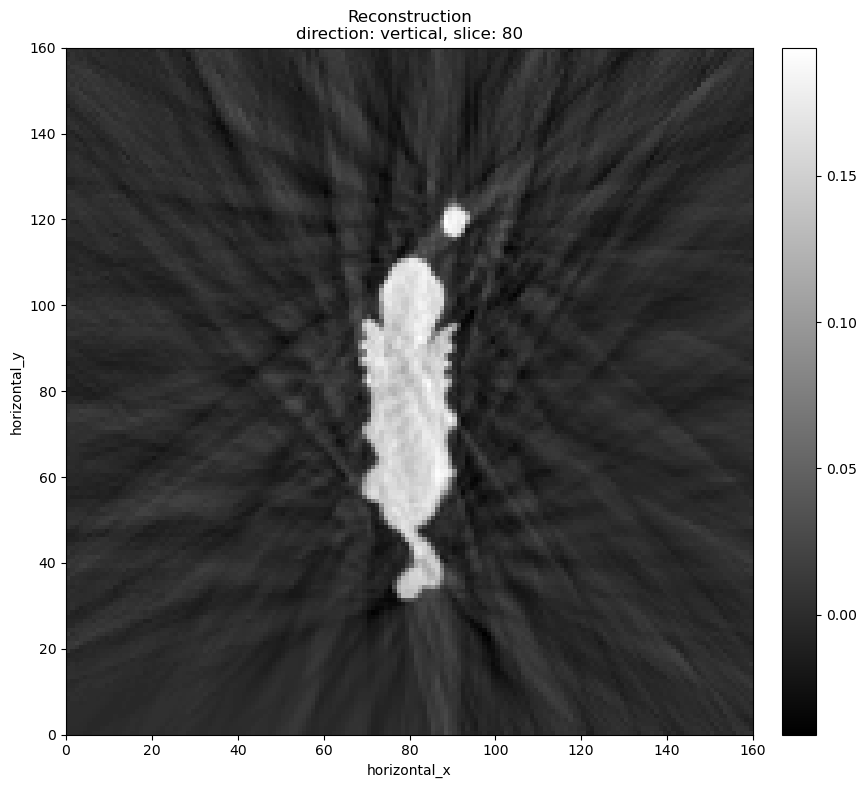

In [21]:
recon = fbp.get_output()

show2D(recon, title='Reconstruction')

In [22]:

from cil.plugins.astra import ProjectionOperator


PO = ProjectionOperator( recon.geometry, absorp_data.geometry)

forward_projection = PO.direct(recon)

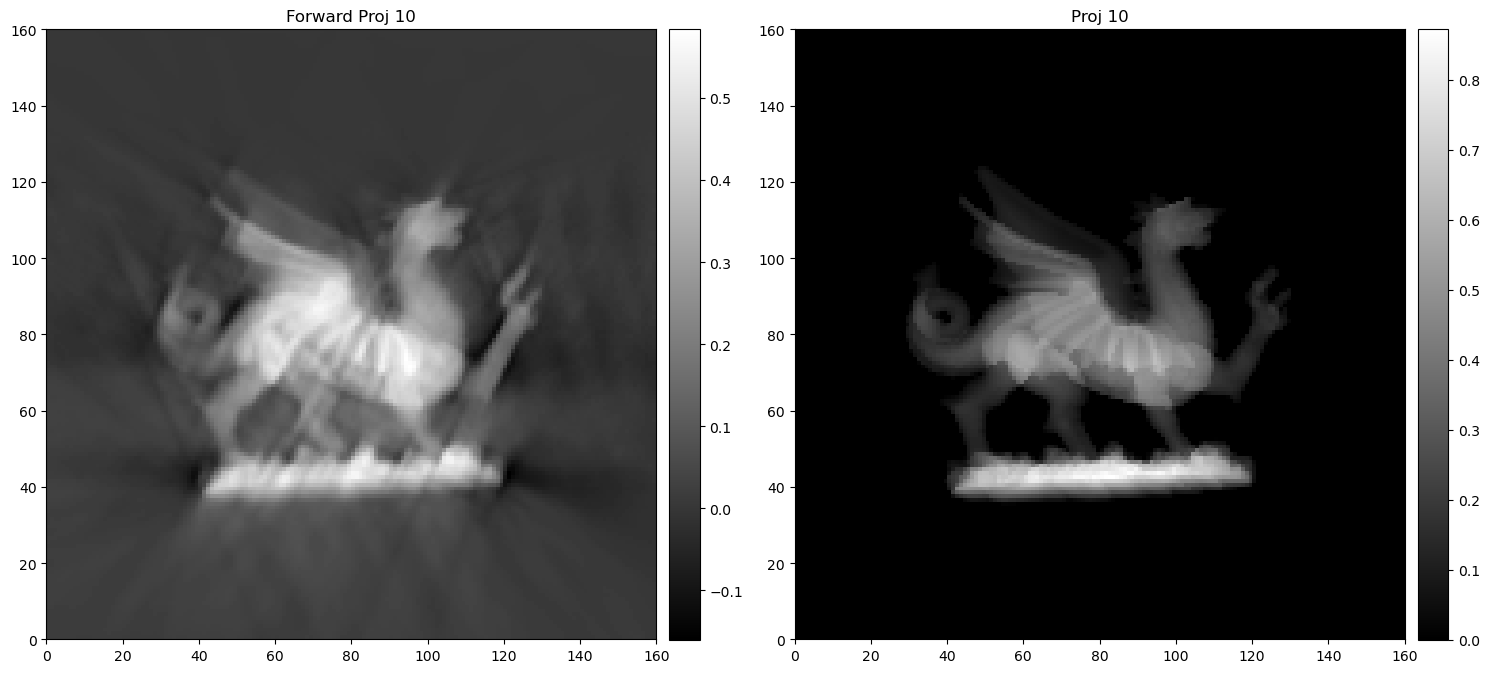

In [23]:
show2D([forward_projection.array[:,100,:], absorp_data.array[:,100,:]], title=["Forward Proj 10", "Proj 10"])

# do some mor

# SIRT

In [24]:
from cil.optimisation.algorithms import CGLS, SIRT

x0 = recon.geometry.copy().allocate(0)

sirt = SIRT(initial=x0, operator=PO, data=absorp_data)
sirt.update_objective_interval = 10
sirt.run(200)

recon_sirt = sirt.solution

c:\Users\lhe97136\AppData\Local\miniconda3\envs\gvxr-tutorials\Lib\site-packages\cil\framework\data_container.py:491: RuntimeWarning: divide by zero encountered in power
  out = pwop(self.as_array() , x2 , *args, **kwargs )


  0%|          | 0/200 [00:00<?, ?it/s]

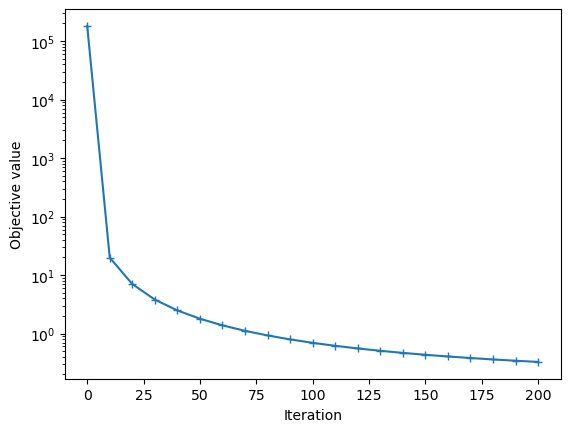

In [25]:
from matplotlib import pyplot as plt
plt.plot(range(0,210,10), sirt.objective,  marker='+');
plt.yscale('log');
plt.xlabel('Iteration');
plt.ylabel('Objective value');

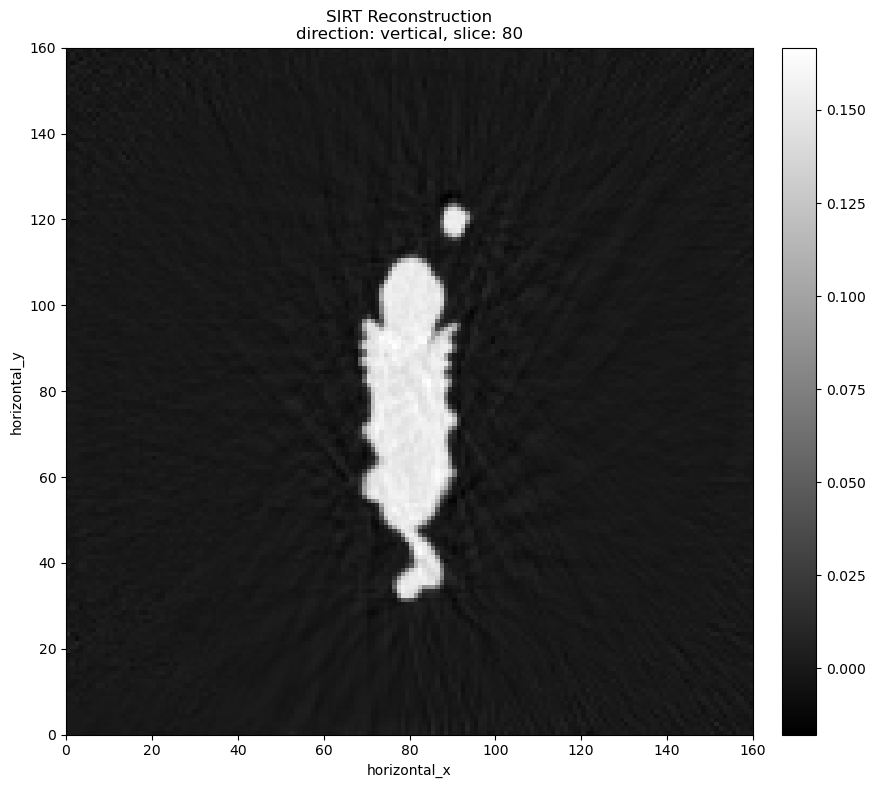

In [26]:
show2D(recon_sirt, title='SIRT Reconstruction')

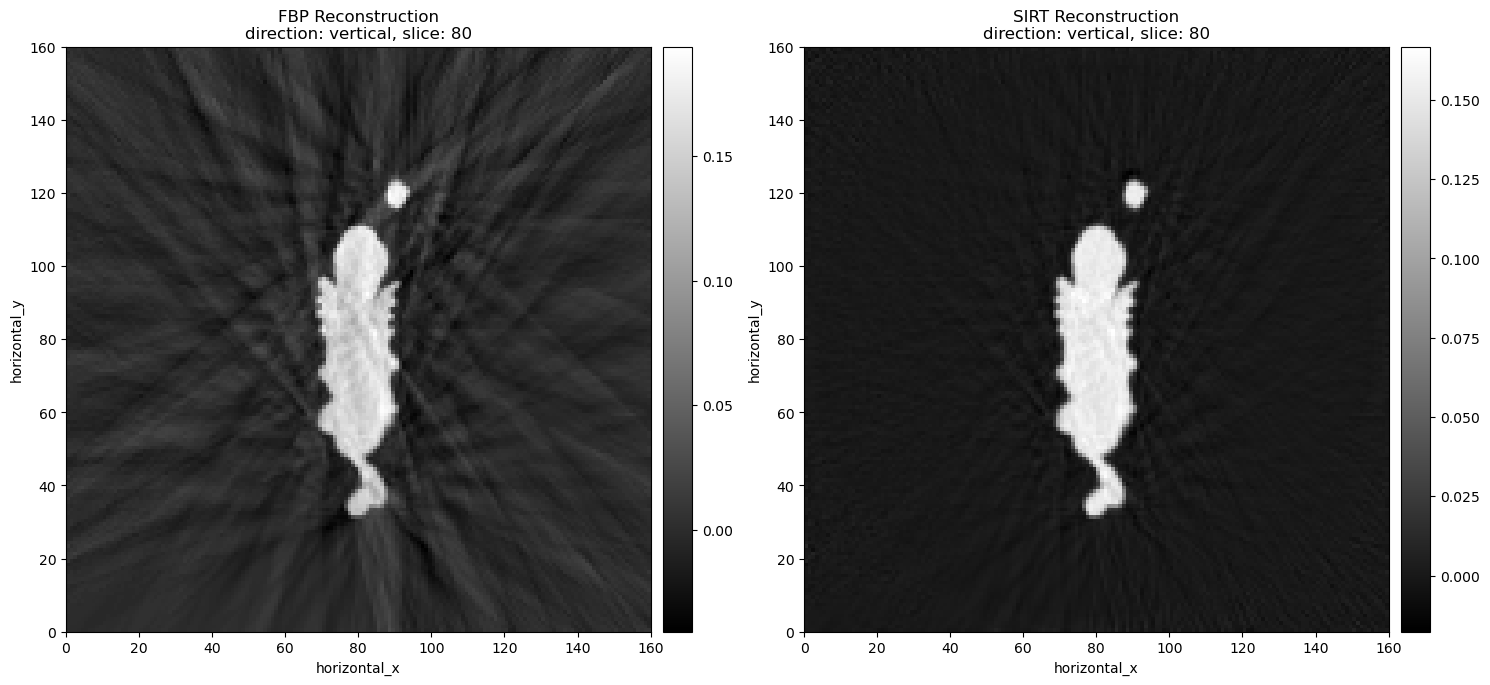

In [27]:
show2D([recon, recon_sirt], title=['FBP Reconstruction', 'SIRT Reconstruction']); # sort put fix range

In [28]:
from cil.io import NEXUSDataWriter
output_file = r"C:\Users\lhe97136\Work\Data\to-delete\nonstand.nxs"

NEXUSDataWriter(file_name=output_file, data=acq_data).write()

NotImplementedError: CONE_FLEX geometry is not supported by NEXUSDataWriter